In [226]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score-

In [227]:
df_real=pd.read_csv('../input/fakenewsnet/BuzzFeed_real_news_content.csv')

In [228]:
df_real.shape

(91, 12)

In [229]:
df_fake=pd.read_csv('../input/fakenewsnet/BuzzFeed_fake_news_content.csv')

In [230]:
df_fake.shape

(91, 12)

In [231]:
df=pd.concat([df_real,df_fake],axis=0)

In [232]:
df.shape

(182, 12)

In [233]:
df['news_type']=df['id'].apply(lambda x: x.split('_')[0])

In [234]:
df.head(2)

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",Real
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",Real


In [235]:
df.shape

(182, 13)

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 90
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              182 non-null    object
 1   title           182 non-null    object
 2   text            182 non-null    object
 3   url             174 non-null    object
 4   top_img         172 non-null    object
 5   authors         141 non-null    object
 6   source          174 non-null    object
 7   publish_date    133 non-null    object
 8   movies          25 non-null     object
 9   images          172 non-null    object
 10  canonical_link  170 non-null    object
 11  meta_data       182 non-null    object
 12  news_type       182 non-null    object
dtypes: object(13)
memory usage: 19.9+ KB


In [237]:
df.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
count,182,182,182,174,172,141,174,133,25,172,170,182,182
unique,182,178,178,171,166,90,28,118,25,169,168,171,2
top,Real_32-Webpage,Clinton Foundation Spent 5.7% on Charity; Rest...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://static.politico.com/da/f5/44342c424c68b...,Terresa Monroe-hamilton,http://politi.co,{'$date': 1474588800000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://static.politico.com/da/f5/44342c424c68b...,http://eaglerising.com/36880/a-hillary-clinton...,{},Fake
freq,1,2,2,2,3,8,32,5,1,2,2,8,91


In [ ]:
## Data Cleaning and Feature Engineering

In [238]:
df.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1, inplace=True)

In [239]:
df.isnull().sum()

title          0
text           0
source         8
movies       157
images        10
news_type      0
dtype: int64

In [240]:


(df.isnull().sum())/(df.shape[0])*100

title         0.000000
text          0.000000
source        4.395604
movies       86.263736
images        5.494505
news_type     0.000000
dtype: float64

In [241]:
df['contain_movies']=df['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [242]:
df['contain_images']=df['images'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [243]:
df.drop(['movies','images'],axis=1,inplace=True)

In [244]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1


In [245]:
real_order=df[df['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

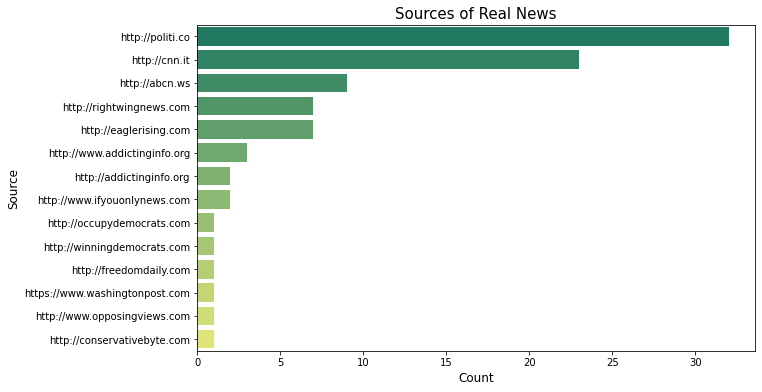

In [246]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=df[df['news_type']=='Real'],order=real_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

In [ ]:
From the above plot we observe that the politi.co reports maximum real news followed by cnn.it with a count of 32 and 23, respectively.

In [ ]:
#### Sources of Publishing Maximum Fake News

In [247]:
fake_order=df[df['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

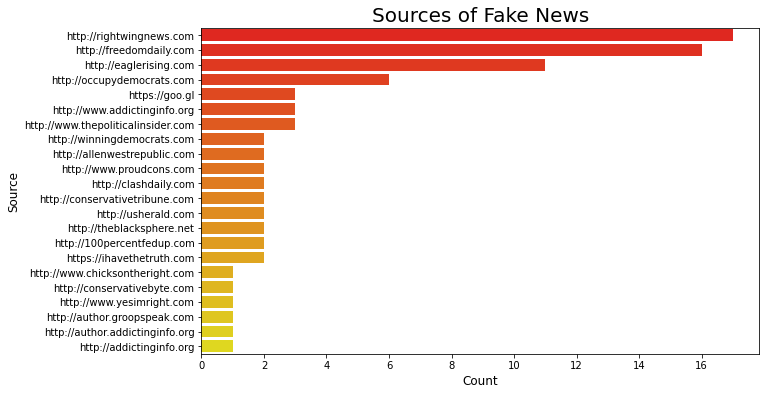

In [248]:
plt.figure(figsize=(10,6))
sns.countplot(y='source',data=df[df['news_type']=='Fake'],order=fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=20)
plt.show()

In [ ]:
Above plot shows that the rightwingsnews reports maximum fakenews with a count of 17. Also, the number of fake news sources are more than the number of real news sources.

In [ ]:
#### Common Sources of Publishing Both Real and Fake News

In [249]:
new=[]
for x in df[df['news_type']=='Fake']['source'].unique():
    if x in df[df['news_type']=='Real']['source'].unique():
        new.append(x)
print(new)

['http://www.addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com', 'http://addictinginfo.org']


In [250]:
df['common']=df['source'].apply(lambda x: x if x in new else 0)

In [251]:
df1=df[df['common']!=0]

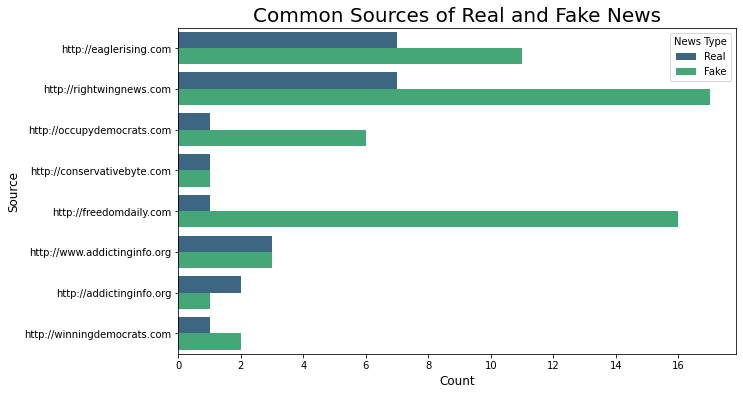

In [252]:
plt.figure(figsize=(10,6))
sns.countplot(y='common',data=df1,hue='news_type',palette='viridis')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

In [ ]:
There are 7 common sources of real and fake news. This is interesting that the fake news are more reported by these sources as compared to real news. The rightwingnews reports maximum fake news but it also reports some real news. Approximaltely, two third of total news reported by rightwings are fake. On the other hand, the freedomdaily which is the second largest fake news reporting source, barely reports the real news. addictinginfo.org is the only single common source which reports real news more than fake news but the total number of the news it reports is very low.

In [ ]:
#### Sources Including Movies in the News 

In [253]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images,common
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1,http://eaglerising.com
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1,0


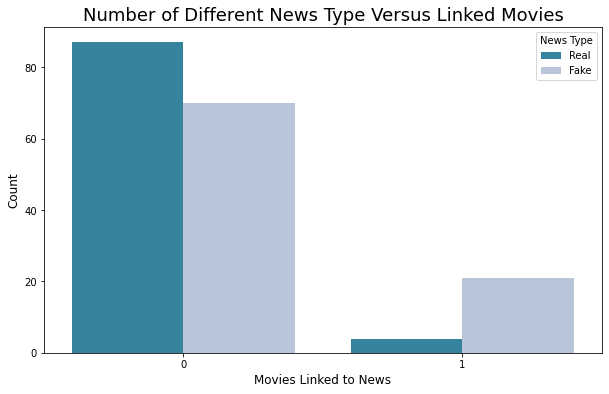

In [254]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_movies', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Movies Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

In [ ]:
From the above plot, we observe that most of the news are reported without including the movie clips, and there are very little articles which includes movie clips. This variable does not provide much useful information in our analysis.

In [ ]:
#### Sources Including Images in the News 

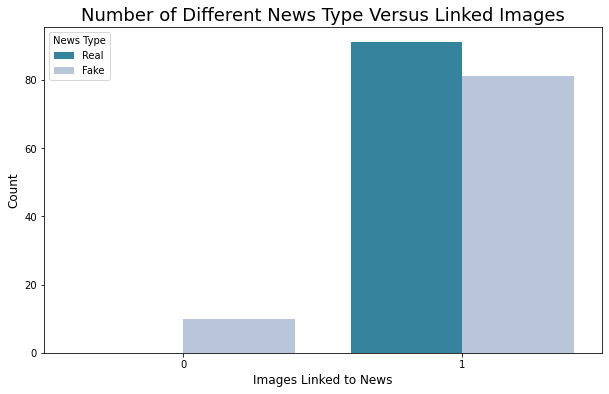

In [255]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_images', data=df, hue='news_type', palette='PuBuGn_r')
plt.xlabel('Images Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='upper left', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

In [ ]:
From the above plot we observe that all the real news sources included images in their articles. We may say that images acts as a proof of thier news. Therefore, this variable reveal that images are an important part of real news articles. The images and movies variables do not give us much details to strenghen our analysis.

In [ ]:
### Analysis of Title and Body of News Articles

In [ ]:
#### Preprocessing Function

In [256]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    
    
    
    
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

In [ ]:
#### Analysis of News Title 

In [ ]:
We use 'final' function to process the title of news articles, then select the top 20 most frequent words in the news title for both categories i.e., real news and fake news. We plot the term frequency of these words in both categories.

In [ ]:
##### Fake News

In [257]:
df_fake=df[df['news_type']=='Fake']

In [258]:
cv1 = CountVectorizer(analyzer=final)
cv1.fit(df_fake['title'])
bow1=cv1.transform(df_fake['title'])

In [259]:
pd.DataFrame(bow1.todense()).shape

(91, 459)

In [260]:
new1=[]
for x in range(0,459):
    new1.append(cv1.get_feature_names()[x])

In [261]:
matrix1=pd.DataFrame(bow1.todense(),columns=new1)

In [262]:
sm1=[]
for x in new1:
    sm1.append(matrix1[x].sum())

In [263]:
trans1=matrix1.transpose()

In [264]:
trans1['sum']=sm1

In [265]:
top1=trans1.sort_values(by='sum', ascending=False).head(20)

In [ ]:
##### Real News

In [266]:
df_real=df[df['news_type']=='Real']

In [267]:
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2=cv2.transform(df_real['title'])

In [268]:
pd.DataFrame(bow2.todense()).shape

(91, 436)

In [269]:
new2=[]
for x in range(0,436):
    new2.append(cv2.get_feature_names()[x])

In [270]:
matrix2=pd.DataFrame(bow2.todense(),columns=new2)

In [271]:
sm2=[]
for x in new2:
    sm2.append(matrix2[x].sum())

In [272]:
trans2=matrix2.transpose()

In [273]:
trans2['sum']=sm2

In [274]:
top2=trans2.sort_values(by='sum', ascending=False).head(20)

In [ ]:
##### Concatenation

In [275]:
top1.drop(list(range(0,91)),axis=1,inplace=True)

In [276]:
top1['type']=['Fake']*20

In [277]:
top2.drop(list(range(0,91)),axis=1,inplace=True)

In [278]:
top2['type']=['Real']*20

In [279]:
conc1=pd.concat([top1,top2])

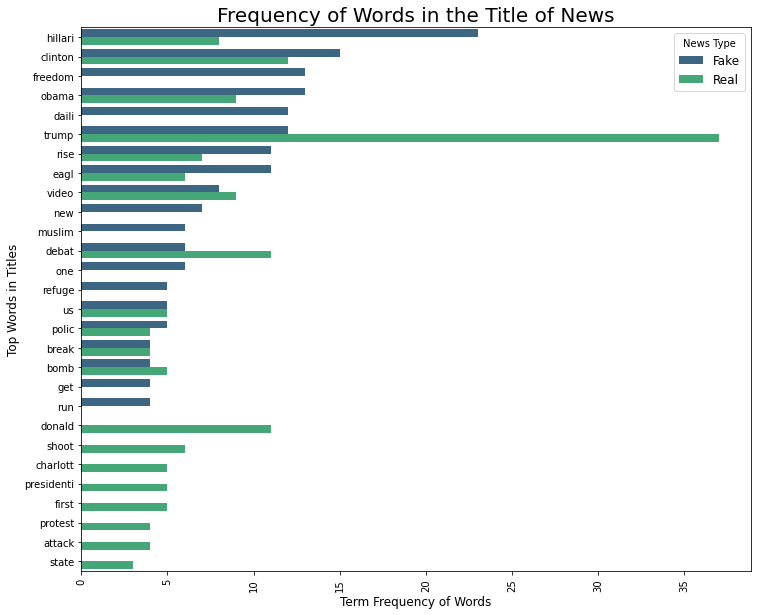

In [280]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc1.index,x='sum',data=conc1,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News',fontsize=20)
plt.show()

In [ ]:
The term frequency plot shows that some words like hillari, clinton, freedom and obama are representative of the title of fake news whereas words like trump, clinton, donald and debat are representative of the title of real news.

In [ ]:
#### Analysis of News Body

In [ ]:
After analyzing the title, we analyze the text body of the news articles. We are interested in finding top 30 representative words in the body of fake news and real news. We perform same steps by calling "final" function on the body of the news article, and then select the top 30 most frequent words in the news title for both categories i,e. real news and fake news. We plot the term frequency of such words in both categories i.e., real news and fake news. We plot these words to visualise the high frequency words associated with fake and real news.

In [ ]:
##### Fake News

In [281]:
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [282]:
pd.DataFrame(bow3.todense()).shape

(91, 4958)

In [283]:
new3=[]
for x in range(0,4958):
    new3.append(cv3.get_feature_names()[x])

In [284]:
matrix3=pd.DataFrame(bow3.todense(),columns=new3)

In [285]:
sm3=[]
for x in new3:
    sm3.append(matrix3[x].sum())

In [286]:
trans3=matrix3.transpose()

In [287]:
trans3['sum']=sm3

In [288]:
top3=trans3.sort_values(by='sum', ascending=False).head(30)

In [ ]:
##### Real News

In [289]:
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])

In [290]:
pd.DataFrame(bow4.todense()).shape

(91, 6529)

In [291]:
new4=[]
for x in range(0,6529):
    new4.append(cv4.get_feature_names()[x])

In [292]:
matrix4=pd.DataFrame(bow4.todense(),columns=new4)

In [293]:
sm4=[]
for x in new4:
    sm4.append(matrix4[x].sum())

In [294]:
trans4=matrix4.transpose()

In [295]:
trans4['sum']=sm4

In [296]:
top4=trans4.sort_values(by='sum', ascending=False).head(30)

In [ ]:
##### Concatenation

In [297]:
top3.drop(list(range(0,91)),axis=1,inplace=True)

In [298]:
top3['type']=['Fake']*30

In [299]:
top4.drop(list(range(0,91)),axis=1,inplace=True)

In [300]:
top4['type']=['Real']*30

In [301]:
conc2=pd.concat([top3,top4])

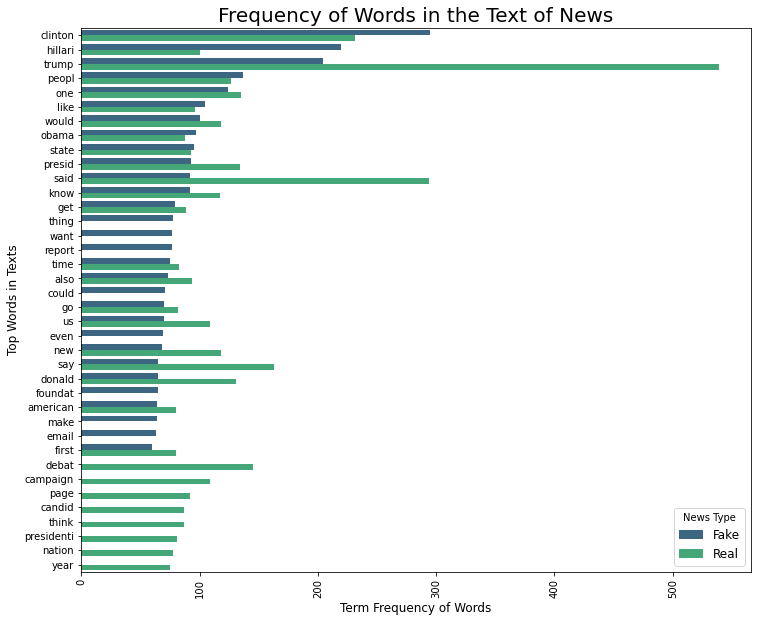

In [302]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc2.index,x='sum',data=conc2,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Texts',fontsize=12)
plt.legend(title='News Type',fontsize=12,loc='lower right')
plt.title('Frequency of Words in the Text of News',fontsize=20)
plt.show()

In [ ]:
From the above plot, we notice that words like trump and clinton are the most frequent words in the news body.
The term frequency plot shows that some words like clinton, hillari and trump are representative of fake news whereas words like trump, said, clinton are representative of real news.

In [ ]:
#### Analysis of Title Length

In [303]:
df['title_length']=df['title'].apply(lambda x: len(x))

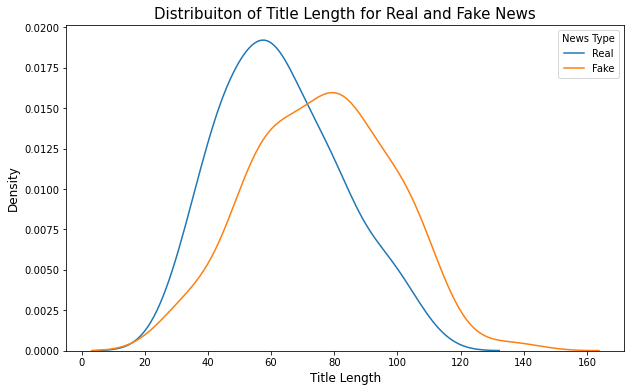

In [304]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['title_length'])
sns.kdeplot(df[df['news_type']=='Fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

In [ ]:
The title length of fake news is slighly larger than the real news. Real news title length distribution is centered with the maximum density at the length of 60, while the center of distribution of title length for fake news is slightly skewed  with the maximum density at the length of 80.

In [ ]:
## Fake/Real News Classification

In [ ]:
### Fake/Real News Detection Based on News Body

In [ ]:
#### Splitting Data into Train and Test Datasets 

In [305]:
X1=df['text']
y1=df['news_type']

In [306]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
#### Random Forest Classifier with Text Preprocessing

In [307]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [308]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [309]:
predictions1=pp.predict(X1_test)

In [310]:
print(confusion_matrix(y1_test, predictions1))
print('\n')
print(classification_report(y1_test, predictions1))

[[20  6]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.77      0.77      0.77        26
        Real       0.79      0.79      0.79        29

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55



In [ ]:
The accuracy of Random Forest Classifier on body with preprocessing is only 78% which means that there are only 78% of news in the test dataset that the classifier predicts correctly. To improve accuracy, we train this model on body without preprocessing.

In [ ]:
#### Random Forest Classifier Without Text Preprocessing

In [311]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [312]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [313]:
predictions2=pp.predict(X1_test)

In [314]:
print(confusion_matrix(y1_test, predictions2))
print('\n')
print(classification_report(y1_test, predictions2))

[[17  9]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.74      0.65      0.69        26
        Real       0.72      0.79      0.75        29

    accuracy                           0.73        55
   macro avg       0.73      0.72      0.72        55
weighted avg       0.73      0.73      0.73        55



In [ ]:
The accuracy of Random Forest Classifier on body without preprocessing is 71%. To improve accuracy we train another model.

In [ ]:
#### Naive Bayes Classifier with Text Preprocessing

In [315]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [316]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [317]:
predictions3=pp.predict(X1_test)

In [318]:
print(confusion_matrix(y1_test, predictions3))
print('\n')
print(classification_report(y1_test, predictions3))

[[22  4]
 [13 16]]


              precision    recall  f1-score   support

        Fake       0.63      0.85      0.72        26
        Real       0.80      0.55      0.65        29

    accuracy                           0.69        55
   macro avg       0.71      0.70      0.69        55
weighted avg       0.72      0.69      0.69        55



In [ ]:
The accuracy of Naive Bayes Classifier on body with preprocessing is 69%. To improve accuracy, we train this model without preprocessing.

In [ ]:
#### Naive Bayes Classifier without Text Preprocessing

In [319]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [320]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [321]:
predictions4=pp.predict(X1_test)

In [322]:
print(confusion_matrix(y1_test, predictions4))
print('\n')
print(classification_report(y1_test, predictions4))

[[25  1]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.60      0.96      0.74        26
        Real       0.92      0.41      0.57        29

    accuracy                           0.67        55
   macro avg       0.76      0.69      0.65        55
weighted avg       0.77      0.67      0.65        55



In [ ]:
The accuracy of Naive Bayes Classifier decreases to 67% on body without preprocessing.To improve accuracy, we train another model.

In [ ]:
#### Passive Aggressive Classifier with Text Preprocessing

In [323]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [324]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [325]:
predictions5=pp.predict(X1_test)

In [326]:
print(confusion_matrix(y1_test, predictions5))
print('\n')
print(classification_report(y1_test, predictions5))

[[21  5]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.78      0.81      0.79        26
        Real       0.82      0.79      0.81        29

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



In [ ]:
The accuracy of Passive Aggressive Classifier on body with preprocessing is 78%. To improve accuracy, we train this model without preprocessing.

In [ ]:
#### Passive Aggressive Classifier without Text Preprocessing

In [327]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [328]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [329]:
predictions6=pp.predict(X1_test)

In [330]:
print(confusion_matrix(y1_test, predictions6))
print('\n')
print(classification_report(y1_test, predictions6))

[[22  4]
 [ 4 25]]


              precision    recall  f1-score   support

        Fake       0.85      0.85      0.85        26
        Real       0.86      0.86      0.86        29

    accuracy                           0.85        55
   macro avg       0.85      0.85      0.85        55
weighted avg       0.85      0.85      0.85        55



In [ ]:
The accuracy of Passive Aggressive Classifier increases to 84% on body without preprocessing.

In [ ]:
### Fake/Real News Detection Based on News Title

In [ ]:
#### Splitting Data into Train and Test Datasets 

In [331]:
X2=df['title']
y2=df['news_type']

In [332]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
#### Random Forest Classifier with Text Preprocessing

In [333]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [334]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [335]:
predictions7=pp.predict(X2_test)

In [336]:
print(confusion_matrix(y2_test, predictions7))
print('\n')
print(classification_report(y2_test, predictions7))

[[17  9]
 [11 18]]


              precision    recall  f1-score   support

        Fake       0.61      0.65      0.63        26
        Real       0.67      0.62      0.64        29

    accuracy                           0.64        55
   macro avg       0.64      0.64      0.64        55
weighted avg       0.64      0.64      0.64        55



In [ ]:
The accuracy of Random Forest Classifier on title is 62%. To improve accuracy, we train this model without preprocessing.

In [ ]:
#### Random Forest Classifier without Text Preprocessing

In [337]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [338]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [339]:
predictions8=pp.predict(X2_test)

In [340]:
print(confusion_matrix(y2_test, predictions8))
print('\n')
print(classification_report(y2_test, predictions8))

[[12 14]
 [10 19]]


              precision    recall  f1-score   support

        Fake       0.55      0.46      0.50        26
        Real       0.58      0.66      0.61        29

    accuracy                           0.56        55
   macro avg       0.56      0.56      0.56        55
weighted avg       0.56      0.56      0.56        55



In [ ]:
The accuracy of Random Forest Classifier on title is increased to 56% on title without preprocessing.To improve accuracy, we train another model.

In [ ]:
#### Naive Bayes Classifier with Text Preprocessing

In [341]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [342]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [343]:
predictions9=pp.predict(X2_test)

In [344]:
print(confusion_matrix(y2_test, predictions9))
print('\n')
print(classification_report(y2_test, predictions9))

[[21  5]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.55      0.81      0.66        26
        Real       0.71      0.41      0.52        29

    accuracy                           0.60        55
   macro avg       0.63      0.61      0.59        55
weighted avg       0.63      0.60      0.59        55



In [ ]:
The accuracy of Naive Bayes classifier on title with preprocessing is 60%. To improve accuracy, we train we train this model on title without preprocessing.

In [ ]:
#### Naive Bayes Classifier without Text Preprocessing

In [345]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [346]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [347]:
predictions10=pp.predict(X2_test)

In [348]:
print(confusion_matrix(y2_test, predictions10))
print('\n')
print(classification_report(y2_test, predictions10))

[[22  4]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.54      0.85      0.66        26
        Real       0.71      0.34      0.47        29

    accuracy                           0.58        55
   macro avg       0.63      0.60      0.56        55
weighted avg       0.63      0.58      0.56        55



In [ ]:
The accuracy of Naive Bayes Classifier on title is reduced to 58% on title without preprocessing.To improve accuracy, we train another model.

In [ ]:
#### Passive Aggressive Classifier with Text Preprocessing

In [349]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [350]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [351]:
predictions11=pp.predict(X2_test)

In [352]:
print(confusion_matrix(y2_test, predictions11))
print('\n')
print(classification_report(y2_test, predictions11))

[[20  6]
 [16 13]]


              precision    recall  f1-score   support

        Fake       0.56      0.77      0.65        26
        Real       0.68      0.45      0.54        29

    accuracy                           0.60        55
   macro avg       0.62      0.61      0.59        55
weighted avg       0.62      0.60      0.59        55



In [ ]:
The accuracy of Passive Aggressive Classifier on title with preprocessing is 62%. To improve accuracy, we train this model without preprocessing.

In [ ]:
#### Passive Aggressive Classifier without Text Preprocessing

In [353]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [354]:
pp.fit(X2_train,y2_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [355]:
predictions12=pp.predict(X2_test)

In [356]:
print(confusion_matrix(y2_test, predictions12))
print('\n')
print(classification_report(y2_test, predictions12))

[[20  6]
 [18 11]]


              precision    recall  f1-score   support

        Fake       0.53      0.77      0.62        26
        Real       0.65      0.38      0.48        29

    accuracy                           0.56        55
   macro avg       0.59      0.57      0.55        55
weighted avg       0.59      0.56      0.55        55



In [ ]:
The accuracy of Passive Aggressive Classifier decreases to 58% on title without preprocessing.

In [ ]:
### Fake/Real News Detection Based on Both Body and Title of News 

In [ ]:
#### Splitting Data into Train and Test Datasets 

In [357]:
df['title_text']=df['title']+': ' +df['text']

In [358]:
X3=df['title_text']
y3=df['news_type']

In [359]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [ ]:
#### Random Forest Classifier with Text Preprocessing

In [360]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [361]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [362]:
predictions13=pp.predict(X3_test)

In [363]:
print(confusion_matrix(y3_test, predictions13))
print('\n')
print(classification_report(y3_test, predictions13))

[[20  6]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.71      0.77      0.74        26
        Real       0.78      0.72      0.75        29

    accuracy                           0.75        55
   macro avg       0.75      0.75      0.75        55
weighted avg       0.75      0.75      0.75        55



In [ ]:
The accuracy of Random Forest Classifier on the mixture of title and body is 75%. To improve accuracy, we train this model on the mixture of title and body without preprocessing.

In [ ]:
#### Random Forest Classifier without Text Preprocessing

In [364]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [365]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [366]:
predictions14=pp.predict(X3_test)

In [367]:
print(confusion_matrix(y3_test, predictions14))
print('\n')
print(classification_report(y3_test, predictions14))

[[16 10]
 [ 6 23]]


              precision    recall  f1-score   support

        Fake       0.73      0.62      0.67        26
        Real       0.70      0.79      0.74        29

    accuracy                           0.71        55
   macro avg       0.71      0.70      0.70        55
weighted avg       0.71      0.71      0.71        55



In [ ]:
The accuracy of Random Forest Classifier on the mixture of title and body without preprocessing is 75%. To improve accuracy, we train another model.

In [ ]:
#### Naive Bayes Classifier with Text Preprocessing

In [368]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [369]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [370]:
predictions15=pp.predict(X3_test)

In [371]:
print(confusion_matrix(y3_test, predictions15))
print('\n')
print(classification_report(y3_test, predictions15))

[[22  4]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.59      0.85      0.70        26
        Real       0.78      0.48      0.60        29

    accuracy                           0.65        55
   macro avg       0.69      0.66      0.65        55
weighted avg       0.69      0.65      0.64        55



In [ ]:
The accuracy of Naive Bayes classifier on the mixture of title and body is 65%. To improve accuracy, we train this model on the mixture of title and body without preprocessing.

In [ ]:
#### Naive Bayes Classifier without Text Preprocessing

In [372]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [373]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [374]:
predictions16=pp.predict(X3_test)

In [375]:
print(confusion_matrix(y3_test, predictions16))
print('\n')
print(classification_report(y3_test, predictions16))

[[25  1]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.57      0.96      0.71        26
        Real       0.91      0.34      0.50        29

    accuracy                           0.64        55
   macro avg       0.74      0.65      0.61        55
weighted avg       0.75      0.64      0.60        55



In [ ]:
The accuracy of Naive Bayes Classifier is reduced to 64% on the mixture of title and body without preprocessing.To improve accuracy, we train another model.

In [ ]:
#### Passive Aggressive Classifier withText Preprocessing

In [376]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [377]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x780a9f6d7c20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [378]:
predictions17=pp.predict(X3_test)

In [379]:
print(confusion_matrix(y3_test, predictions17))
print('\n')
print(classification_report(y3_test, predictions17))

[[21  5]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.72      0.81      0.76        26
        Real       0.81      0.72      0.76        29

    accuracy                           0.76        55
   macro avg       0.77      0.77      0.76        55
weighted avg       0.77      0.76      0.76        55



In [ ]:
The accuracy of Passive Aggressive Classifier on the mixture of title and body with preprocessing is 76%. To improve accuracy, we train this model without preprocessing.

In [ ]:
#### Passive Aggressive Classifier without Text Preprocessing

In [380]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [381]:
pp.fit(X3_train,y3_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', PassiveAggressiveClassifier())])

In [382]:
predictions18=pp.predict(X3_test)

In [383]:
print(confusion_matrix(y3_test, predictions18))
print('\n')
print(classification_report(y3_test, predictions18))

[[23  3]
 [ 4 25]]


              precision    recall  f1-score   support

        Fake       0.85      0.88      0.87        26
        Real       0.89      0.86      0.88        29

    accuracy                           0.87        55
   macro avg       0.87      0.87      0.87        55
weighted avg       0.87      0.87      0.87        55



In [ ]:
**The accuracy of Passive Aggressive Classifier increases to 87% on the mixture of title and body without preprocessing.**

In [384]:
print('Text_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions1)))
print('Text_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions2)))
print('Text_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions3)))
print('Text_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions4)))
print('Text_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions5)))
print('Text_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions6)))
print('\n')
print('Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions7)))
print('Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions8)))
print('Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions9)))
print('Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions10)))
print('Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions11)))
print('Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions12)))
print('\n')
print('Text&Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions13)))
print('Text&Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions14)))
print('Text&Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions15)))
print('Text&Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions16)))
print('Text&Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions17)))
print('Text&Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions18)))

Text_Random Forest Classifier_With Text Preprocessing:  78.0
Text_Random Forest Classifier_Without Text Preprocessing:  73.0
Text_Naive Bayes Classifier_With Text Preprocessing:  69.0
Text_Naive Bayes Classifier_Without Text Preprocessing:  67.0
Text_Passive Aggressive Classifier_With Text Preprocessing:  80.0
Text_Passive Aggressive Classifier_Without Text Preprocessing:  85.0


Title_Random Forest Classifier_With Text Preprocessing:  64.0
Title_Random Forest Classifier_Without Text Preprocessing:  56.0
Title_Naive Bayes Classifier_With Text Preprocessing:  60.0
Title_Naive Bayes Classifier_Without Text Preprocessing:  58.0
Title_Passive Aggressive Classifier_With Text Preprocessing:  60.0
Title_Passive Aggressive Classifier_Without Text Preprocessing:  56.0


Text&Title_Random Forest Classifier_With Text Preprocessing:  75.0
Text&Title_Random Forest Classifier_Without Text Preprocessing:  71.0
Text&Title_Naive Bayes Classifier_With Text Preprocessing:  65.0
Text&Title_Naive Bayes Cla

In [ ]:
* We observe that 87% accuracy is obtained on the test dataset for Passive Aggressive Classifier on combined (body & title) feature matrix without text preprocessing. As 84% accuracy is obtained on the test dataset for Passive Aggressive Classifier on text feature without text preprocessing, it seems that combining titles with body improves the accuracy of the model to 87%. Regarding the preprocessing, it should be mentioned that although some phrases and bigrams should be cleaned and preprocessed, removing stop words and stemming might not be a good idea in this specific dataset as we might loose some langauge information.Therefore, we conclude that Passive Aggressive model on the combined feature matrix without text preprocessing is the best classifcation model in our analysis that can categorize the real and fake news with maximum accuracy.